In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sts
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import warnings as warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка и создание новых признаков

Сначала давайте объединим наши таблицы, чтобы из четырёх датасетов сделать два, с которыми мы будем работать(мы можем это сделать благодаря общему столбцу pid и файлу item.scv, который содержит информацию о товаре). main_df будет обучающей выборкой, которую мы поисследуем в EDA и с помощью которой потом обучим модель(если получится), а test_df будет тестовой выборкой, с помощью которой мы оценим нашу модель.

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Данные для проекта/train.csv",sep = "|")
df_item = pd.read_csv("https://raw.githubusercontent.com/Tiiiimmy/Andan_final_project/refs/heads/main/Data_for_project/items.csv", sep = "|")
main_df = pd.merge(df_train, df_item, how='left', on='pid' )


df_class = pd.read_csv("/content/drive/MyDrive/Данные для проекта/class.csv",sep = "|")
df_class.set_index('lineID',inplace=True,drop=True)
df_realclass = pd.read_csv("https://raw.githubusercontent.com/Tiiiimmy/Andan_final_project/refs/heads/main/Data_for_project/realclass.csv",sep = "|")
df_realclass.rename(columns={'revenue':'actual_revenue'},inplace=True)
df_realclass.set_index("lineID",inplace=True,drop=True)
test_df = df_class.join(df_realclass,on='lineID',how='inner')
test_df = pd.merge( test_df, df_item, how='left', on='pid' )

**Пропуски**

Поглядим, есть ли у нас пропуски и что с этим можно сделать

In [4]:
print(main_df.isna().mean())
print(test_df.isna().mean())

lineID             0.000000
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    0.036534
click              0.000000
basket             0.000000
order              0.000000
price              0.000000
revenue            0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.070437
genericProduct     0.000000
salesIndex         0.000000
category           0.031710
campaignIndex      0.830176
rrp                0.000000
dtype: float64
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    0.031389
price              0.000000
actual_revenue     0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.061086
genericProduct     0.000000
salesIndex         0.000000
categ

В campaignIndex почти 80% пропусков, то есть очень мало продуктов участвуют в какой-то рекламной компании. При этом у нас есть adFlag, который показывает, участвует ли продкут в рекламной компании. Я решил, что для исследования про динамическое ценообразование хватит и просто факта, что продукт участвует в рекламной компании, поэтому удалил этот столбец.

In [5]:
main_df = main_df.drop('campaignIndex', axis=1)
test_df = test_df.drop('campaignIndex', axis=1)

В competitor price не так много пропусков и поскольку это, по сути, столбец про наименьшие рыночные цены на каждую позицию, то можно просто заменить эти три процента средним по столбцу.

In [6]:
main_df['competitorPrice'] = main_df['competitorPrice'].fillna(main_df['competitorPrice'].mean())
test_df['competitorPrice'] = test_df['competitorPrice'].fillna(test_df['competitorPrice'].mean())

Проверим, есть ли в столбце category нули и, если нет, просто заменим все пропуски нулями, обозначающими, что категория товара не определена. Так как это категориальный признак, это нам никак не повредит. Такой же трюк проделаем с pharmForm: для неизвествных нам форм так и укажем -- 'Unknown'.

In [7]:
print((main_df['category'] == 0).any())
print((test_df['category'] == 0).any())

False
False


Нулей нет -- работаем

In [8]:
main_df['category'] = main_df['category'].fillna(0)
test_df['category'] = test_df['category'].fillna(0)
main_df['pharmForm'] = main_df['pharmForm'].fillna('Unknown')
test_df['pharmForm'] = test_df['pharmForm'].fillna('Unknown')

In [9]:
print(main_df.isna().mean())
print(test_df.isna().mean())

lineID             0.0
day                0.0
pid                0.0
adFlag             0.0
availability       0.0
competitorPrice    0.0
click              0.0
basket             0.0
order              0.0
price              0.0
revenue            0.0
manufacturer       0.0
group              0.0
content            0.0
unit               0.0
pharmForm          0.0
genericProduct     0.0
salesIndex         0.0
category           0.0
rrp                0.0
dtype: float64
day                0.0
pid                0.0
adFlag             0.0
availability       0.0
competitorPrice    0.0
price              0.0
actual_revenue     0.0
manufacturer       0.0
group              0.0
content            0.0
unit               0.0
pharmForm          0.0
genericProduct     0.0
salesIndex         0.0
category           0.0
rrp                0.0
dtype: float64


**Типы данных**
Поменяем тип столбца category на category и тип столбца day на date(последнее просто удобнее будет, так-то здесь это непринципиально, день можно выбрать любой, в данных об этом ничего нет).

In [10]:
main_df['category'] = main_df['category'].astype('category')
test_df['category'] = test_df['category'].astype('category')
main_df['day'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(main_df['day'] - 1, unit='D')
test_df['day'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['day'] - 1, unit='D')

__Создание новых переменных:__
нам для наших целей могут быть полезные разные переменные связанные с ценами. Точно хотелось бы посмотреть на превышение наших цен над рыночными, поэтому я решил создать столбец, где это будет показано и столбец, где будет указано, на сколько превышает.

In [11]:
main_df['competitor_cheaper'] = main_df['price'] > main_df['competitorPrice']
test_df['competitor_cheaper'] = test_df['price'] > test_df['competitorPrice']

main_df['price_difference'] = main_df['price'] - main_df['competitorPrice']
test_df['price_difference'] = test_df['price'] - test_df['competitorPrice']

main_df['discount'] = main_df['rrp'] - main_df['price']
test_df['discount'] = test_df['rrp'] - test_df['price']

main_df['competitor_cheaper'] = main_df['competitor_cheaper'].astype(int)
test_df['competitor_cheaper'] = test_df['competitor_cheaper'].astype(int)

__Итоговый main_df__:

In [12]:
main_df

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,content,unit,pharmForm,genericProduct,salesIndex,category,rrp,competitor_cheaper,price_difference,discount
0,1,2024-01-01,6570,0,2,14.60,1,0,0,16.89,...,50,ML,TRO,0,40,193.0,18.25,1,2.29,1.36
1,2,2024-01-01,14922,1,1,8.57,0,1,0,8.75,...,50,ST,TAB,1,40,66.0,18.81,1,0.18,10.06
2,3,2024-01-01,16382,0,1,14.77,0,1,0,16.06,...,2X50,ML,STI,0,53,40.0,18.48,1,1.29,2.42
3,4,2024-01-01,1145,1,1,6.59,0,0,1,6.55,...,60,G,GEL,0,40,25.0,9.31,0,-0.04,2.76
4,5,2024-01-01,3394,0,1,4.39,0,0,1,4.14,...,25X2,ST,KOM,0,53,14.0,8.13,0,-0.25,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2755999,2024-04-01,15767,0,1,22.41,1,0,0,18.64,...,15,ML,LOT,0,53,15.0,24.75,0,-3.77,6.11
2755999,2756000,2024-04-01,2087,0,1,36.87,1,0,0,43.18,...,200,ST,KAP,0,40,100.0,46.09,1,6.31,2.91
2756000,2756001,2024-04-01,2944,0,1,4.71,1,0,0,5.59,...,25,ST,DRA,0,53,1.0,5.88,1,0.88,0.29
2756001,2756002,2024-04-01,3853,1,1,6.59,0,1,0,6.33,...,50,G,SAL,0,40,90.0,9.58,0,-0.26,3.25


# EDA

Для начала составим матрицу корреляций, чтобы посмотреть на связь различных признаков и понять, что было бы неплохо поизучать в данных.

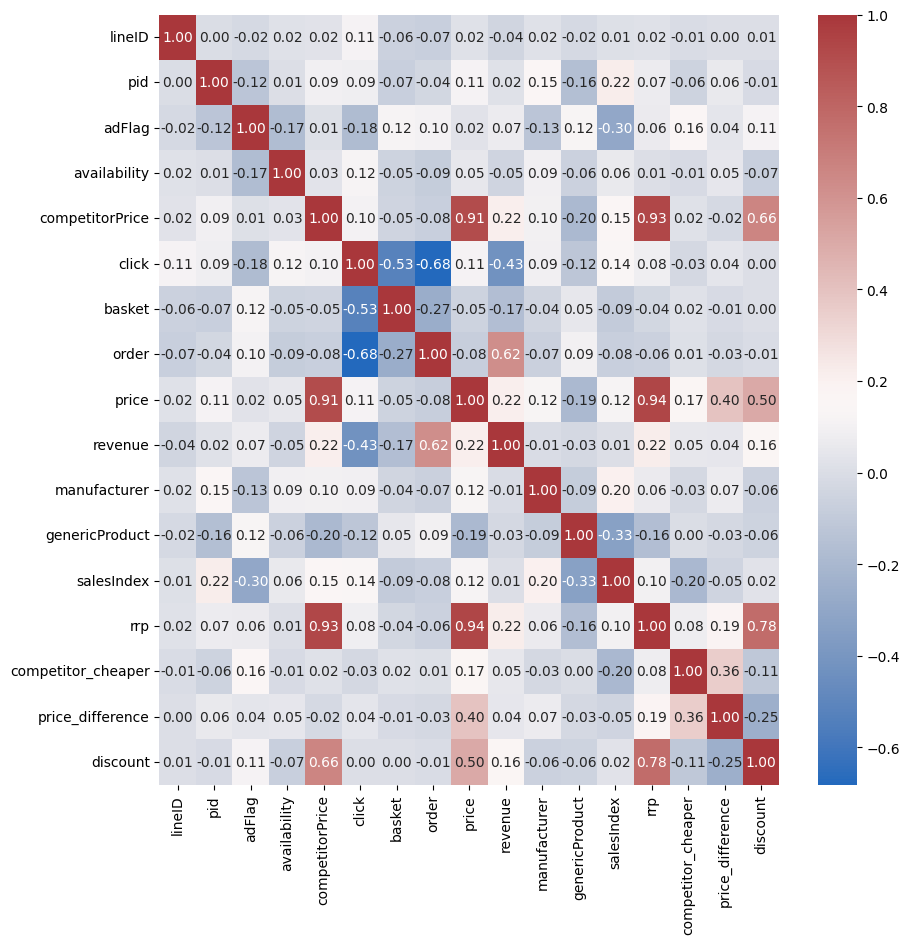

In [13]:
numeric_data = main_df.select_dtypes(include=['float64', 'int'],)
plt.figure(figsize=(10, 10))
sns.heatmap(numeric_data.corr(),cmap="vlag", annot=True, fmt="0.2f")
plt.show()

Давайте даже уберём всё, что по модулю меньше 0.2, чтобы было удобнее смотреть:

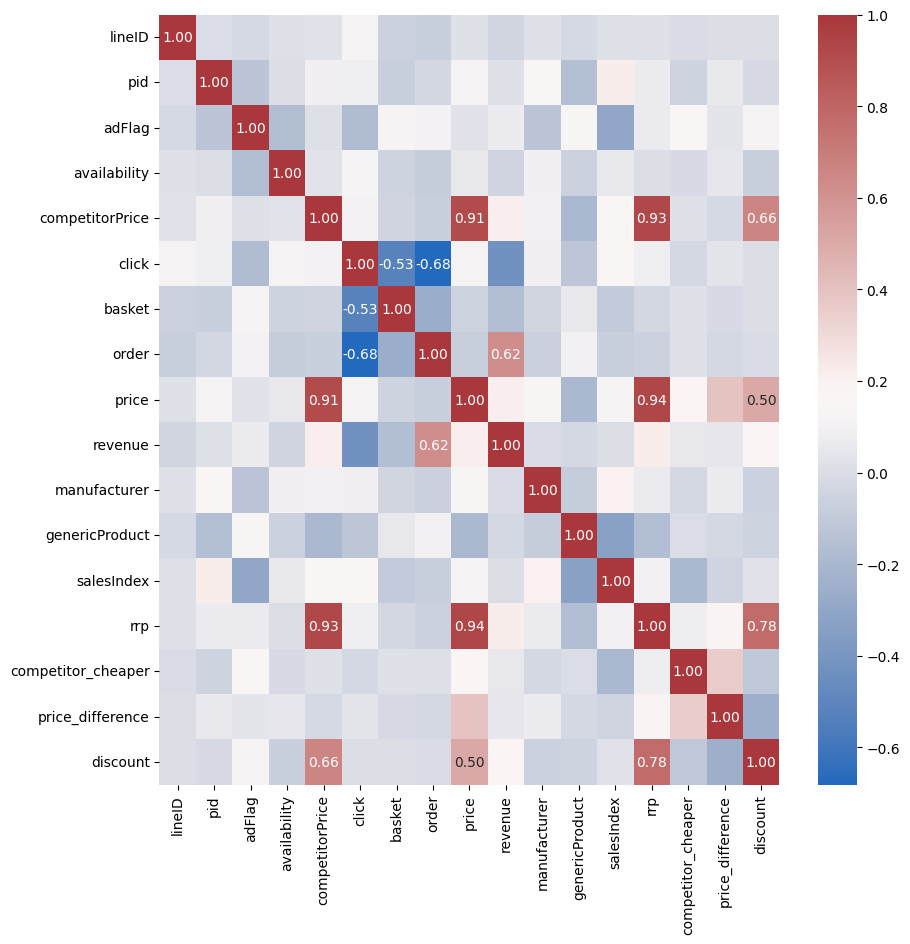

In [31]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(numeric_data.corr(),cmap="vlag", annot=True, fmt="0.2f")
for t in ax.texts:
    if float(t.get_text()) >= 0.5 or float(t.get_text()) <= -0.5:
        t.set_text(t.get_text())
    else:
        t.set_text("")

Теперь можно проанализировать полученные результаты:
Почему, например, наша цена и цена конкурентов сильно коррелирует с рекомендованной розничной примерно понятно, так же, как и связь переменных rrp и price с переменной discounts(мы с помощью них сделали эту переменную).А вот со связью price и competitor price и click и order интересно поработать

Таким образом, ожно выделить два основных направления, которые интересно поизучать:
1. Поскольку аптека ввела динамическое ценообразование  прогнозировать нам придётся выручку, интересно было бы посмотреть на переменные, связанные с этими показателями.
2. У нас есть достаточно много информации про действия пользователей, что может быть полезно для прогнозирования выручки.

Начнём с первого:
Интересно посмотреть есть ли связь между динамически сформированными ценами нашей аптеки и ценами конкурентов(по сути, рыночными). Построим для этого диаграмму рассеивания.

Окажется, что присутствует линейная положительная связь между нашей ценой и ценой конкурентов. Также видно, что есть серьёзные выбросы с нашей стороны(цены около 350, когда рыночные не превышают 25).

Text(0, 0.5, 'Рыночная цена')

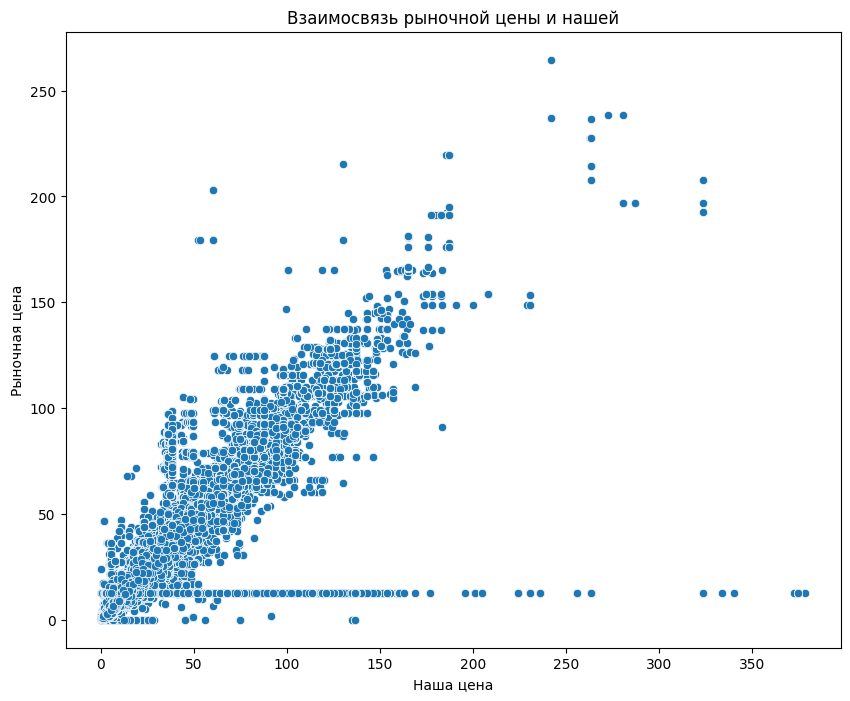

In [15]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=main_df, x='price', y='competitorPrice')
plt.title('Взаимосвязь рыночной цены и нашей')
plt.xlabel('Наша цена')
plt.ylabel('Рыночная цена')

Если, к тому же, проверить как отличаются наша средняя цена от их, то окажется, что несмотря на наличие положительной линейной связи между нашими ценами, аптеке благодаря динамическому ценообразованию удаётся ставить цены выше в 71% случаев

In [16]:
print(f"Доля случаев превышения нашей цены над рыночной : {main_df['competitor_cheaper'].mean():.2f}")
print(main_df['competitorPrice'].mean())
print(main_df['price'].mean())

Доля случаев превышения нашей цены над рыночной : 0.71
12.772879581940538
13.850083294539232


Как это тогда отражается на прибыли аптеки?

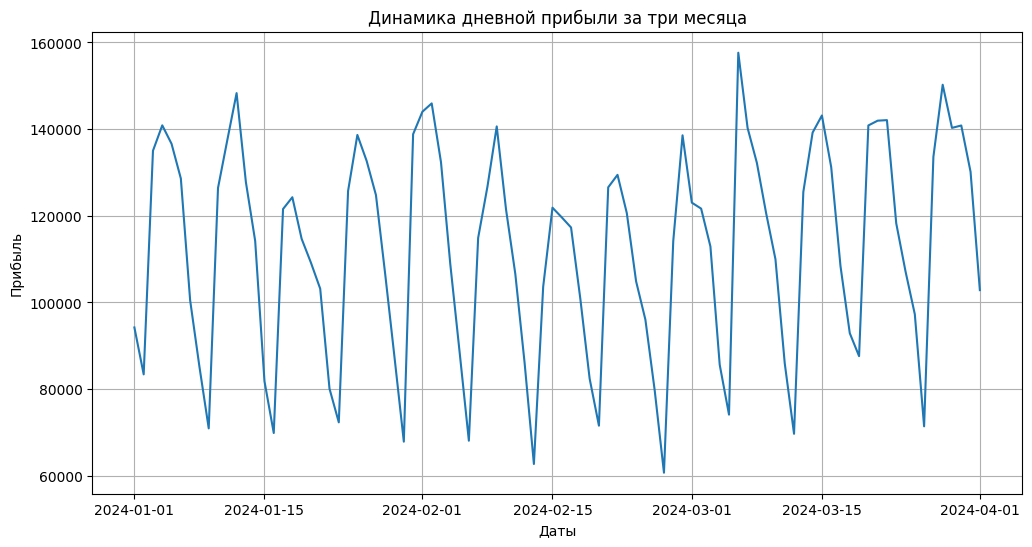

In [17]:
daily_profit = main_df.groupby('day')['revenue'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_profit.index, daily_profit.values)
plt.xlabel('Даты')
plt.ylabel('Прибыль')
plt.title('Динамика дневной прибыли за три месяца')
plt.grid(True)
plt.show()



Так не скажешь, сделаем барплот

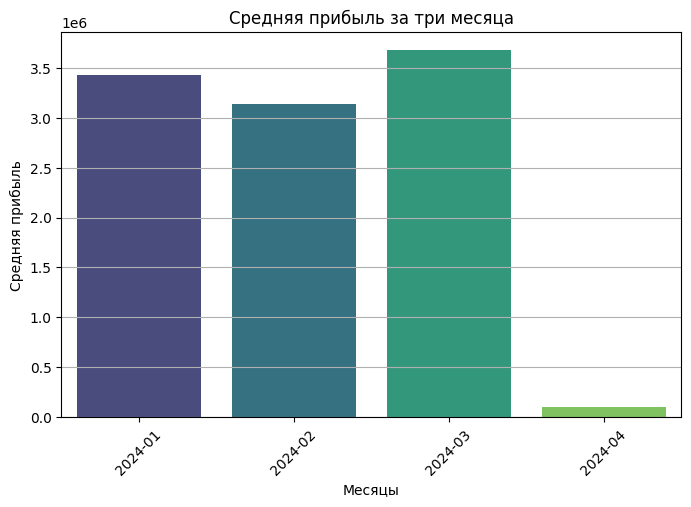

In [37]:
warnings.filterwarnings("ignore")

daily_profit = daily_profit.reset_index()

daily_profit['month'] = daily_profit['day'].dt.to_period('M')


monthly_profit = daily_profit.groupby('month')['revenue'].sum().reset_index()

monthly_profit['month'] = monthly_profit['month'].dt.strftime('%Y-%m')

plt.figure(figsize=(8, 5))
sns.barplot(x='month', y='revenue', data=monthly_profit, palette='viridis')
plt.title('Средняя прибыль за три месяца')
plt.xlabel('Месяцы')
plt.ylabel('Средняя прибыль')
plt.grid(axis='y')
plt.xticks(rotation=45)

plt.show()

По трём месяцам, конечно, сложно, сказать, но в третий месяц прибль стала уже ощутима больше, чем в первые два.

Но насколько это связано именно с ценами и с реакцией людей на них? Можно построит диаграмму рассеивания для цены и прибыли.

Text(0, 0.5, 'Прибыль')

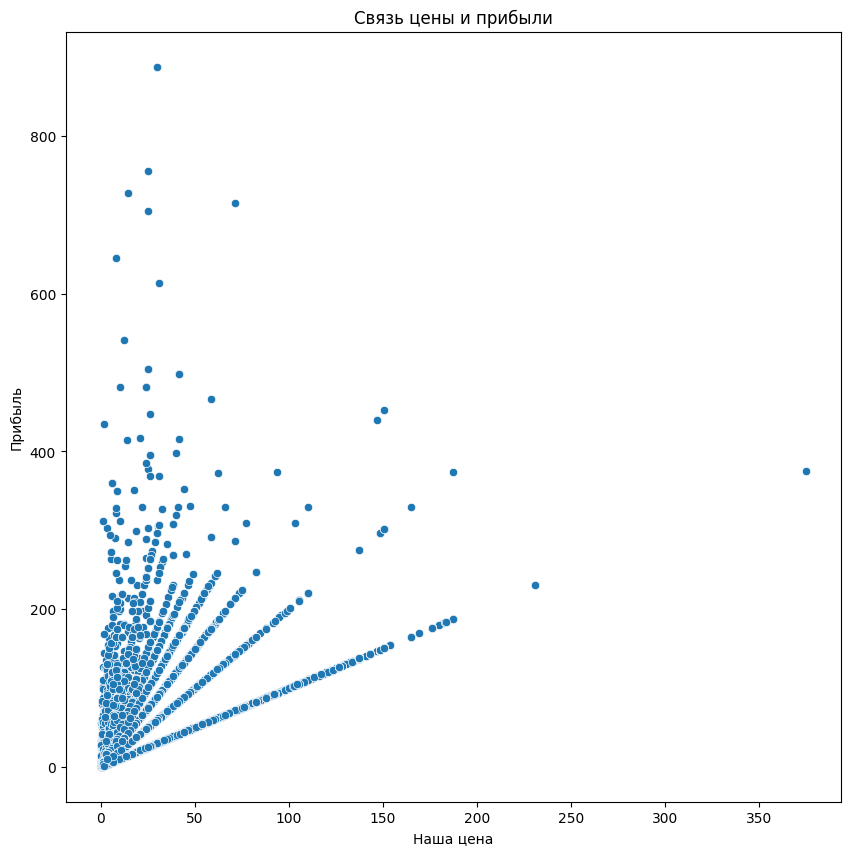

In [19]:
plt.figure(figsize=(10, 10))
df_temp = main_df[main_df['order']==1]
sns.scatterplot(data=df_temp, x='price', y='revenue')
plt.title('Связь цены и прибыли')
plt.xlabel('Наша цена')
plt.ylabel('Прибыль')

При небольшой цене выручка особо не растёт. Но при росте цены наша выручка строко линейно начинает зависеть от цены. Это очень похоже как раз на то, что может дать динамическое ценообразование: если формировать цену динамически, исходя из спроса в реальном времени, то может оказаться, что часть людей(готовых платить много) на самом деле может заплатить даже больше, чем мы думаем. Это отчасти подтверждается выбросами на диаграмме, где мы смотрели связь нашей цены и рыночной -- на рынке даже подумать не могли, что можно продать за ту цену, которая сформировалась у нас динамически. Возможно, именно такое ценообразование повлияло на рост прибыли в третьем месяце.

Давайте попробуем посмотреть на распределение прибыли(её логарифма, поможет немного сгладить выбросы и заодно проще будет работать именно с изменением прибыли)

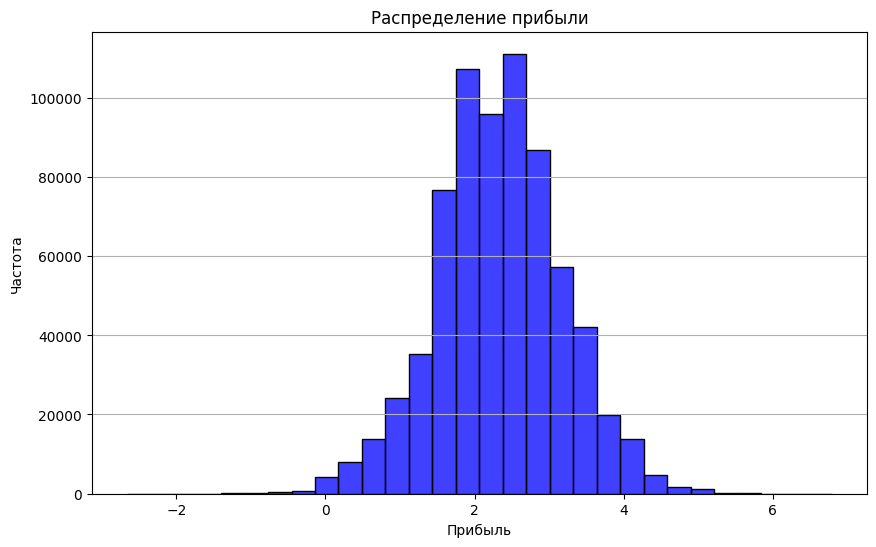

In [44]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 6))
sns.histplot(np.log(main_df['revenue']), bins=30, color='blue')
plt.title('Распределение прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

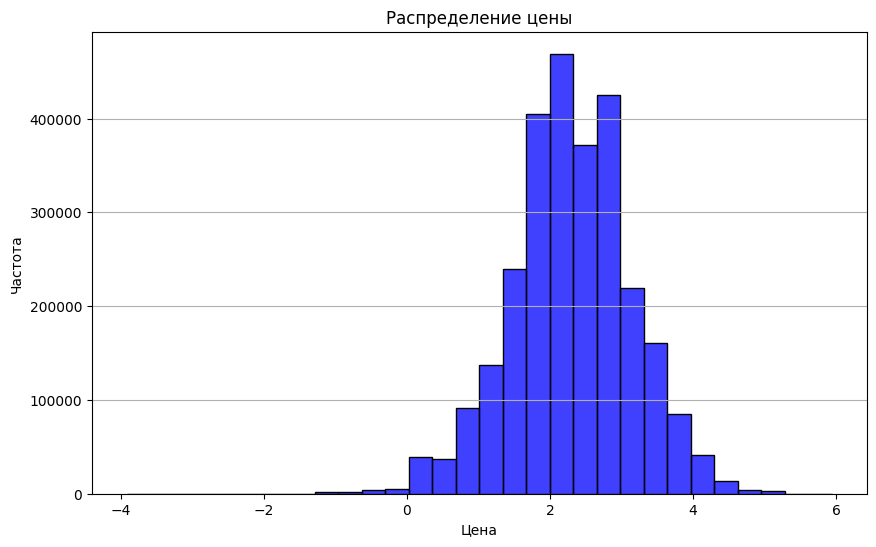

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(main_df['price']), bins=30, color='blue')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

__Немного о возможных гипотезах:__Логарифм прибыли выглядит похоже на нормальное рапсределние(по идее это не совсем оно, так как "хвосты" должны быть тяжелее. Возможно, мы можем сказать,что при большой цене, математическое ожидание логарфма прибыли будет равно математическому ожиданию логарифма нашей цены(раз уж они так хорошо связаны на больших значениях). Тогда получится, что наше ожидаемое изменение прибыли будет равно нашему ожидаемому изменению цены. Возможно это поможет нам лучше прогнозировать прибыль.

__А что с действиями покупателей?__


Рассмотрим второе направление и поработаем с конверсией.

Text(0, 0.5, 'Количество действий каждого типа')

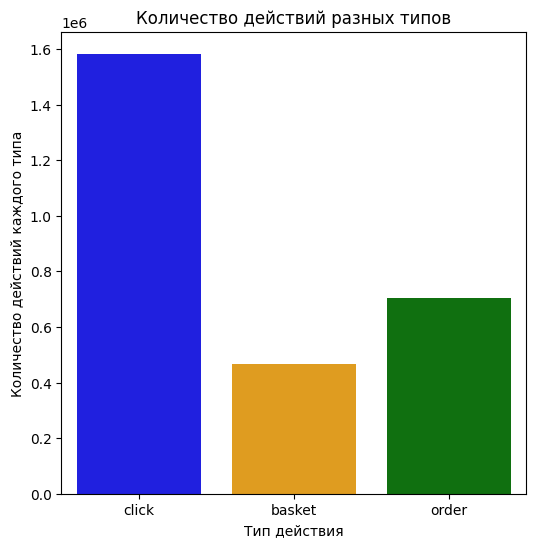

In [33]:
action_counts = main_df[['click', 'basket', 'order']].sum()

colours = ['blue', 'orange', 'green']

plt.figure(figsize=(6, 6))
sns.barplot(x=action_counts.index, y=action_counts.values, hue=action_counts.index, palette=colours, legend=False)
plt.title('Количество действий разных типов')
plt.xlabel('Тип действия')
plt.ylabel('Количество действий каждого типа')

Посчитаем также конверсию.

In [32]:
conversion_click_basket = (main_df['basket'].sum() / main_df['click'].sum())
conversion_click_order = (main_df['order'].sum() / main_df['click'].sum())
conversion_basket_order = (main_df['basket'].sum() / main_df['order'].sum())

print("Количество кликов ,приведших к попаданию товара в корзину:", conversion_click_basket)
print("Количество кликов ,приведших к заказу:", conversion_click_order)
print("Количество попаданий в корзину,приведших к заказу:", conversion_basket_order)

Количество кликов ,приведших к попаданию товара в корзину: 0.2957278338062214
Количество кликов ,приведших к заказу: 0.4454624542037759
Количество попаданий в корзину,приведших к заказу: 0.6638670240678495


Конверсия достаточно понятная, гипотез я не придумал, но это может быть полезно для прогнозирования прибыл(в итоге нет)

Можно попробовать посмотреть на совпадение столбцов 'adFlag' и 'order' и 'click'

In [24]:
share_matches = (main_df['adFlag'] == main_df['order']).sum() / len(main_df)
share_matches2 = (main_df['adFlag'] == main_df['click']).sum() / len(main_df)

print("Количество совпадений:", share_matches)
print("Количество совпадений:", share_matches2)

Количество совпадений: 0.6312808803183451
Количество совпадений: 0.39032794957044675


И попробовать визуализировать это

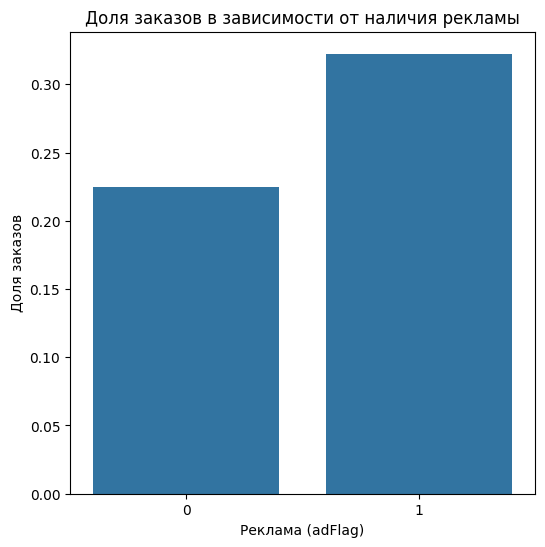

In [25]:
grouped = main_df.groupby('adFlag')['order'].mean()
plt.figure(figsize=(6, 6))
sns.barplot(x=grouped.index, y=grouped.values)
plt.title('Доля заказов в зависимости от наличия рекламы')
plt.xlabel('Реклама (adFlag)')
plt.ylabel('Доля заказов')
plt.show()

В целом, различия между показом и не показом рекламы незначительны. Да и корреляция между двумя этими признаками была очень маленькой.
Можно в таком случае выдвинуть гипотезу, что участие товара в рекалманой компании не влияет на его шансы быть купленным.

# Гипотезы и их проверка

**Первая гипотеза**

Нулевая гипотеза ($H_0$): Математические ожидания распределений логарифмов цены и прибыли равны.

Альтернативная гипотеза ($H_1$): Математические ожидания распределений логарифмов цены и прибыли не равны.

Поскольку наши распределения близки к нормальному, то можно проверить это и, если всё будет хорошо с нормальностью использовать для проверки двухсторонний t-тест. Если с нормальностью будет плохо, то можно будет использовать какой-нибудь непараметрический тест(я выбрал тест Манна-Уитни).

Нормальность проверим с помощью теста Шапиро-Уилка.

Все три теста будем подключать из библиотеки scipy.stats


In [36]:
warnings.filterwarnings("ignore")

main_df['log_price'] = np.log(main_df['price'])
main_df['log_profit'] = np.log(main_df['revenue'])


shapiro_price = shapiro(main_df['log_price'])  # Проверка нормальности распределения
shapiro_profit = shapiro(main_df['log_profit'])

print(f"Тест Шапиро-Уилка для цены: p-value = {shapiro_price.pvalue}")
print(f"Тест Шапиро-Улика для прибыли: p-value = {shapiro_profit.pvalue}")

def interpret_p_value(p_value, alpha=0.05):


  '''
  Эта функция нужна, чтобы сразу вывести интерпретацию результата теста

  '''

  if p_value > alpha:
      return "Нет статистически значимых различий."
  else:
      return "Есть статистически значимые различия."


# Если p-value > 0.05, распределение считается нормальным и мы используем t-тест
if shapiro_price.pvalue > 0.05 and shapiro_profit.pvalue > 0.05:
    t_stat, p_value = ttest_ind(main_df['log_price'], main_df['log_profit']) # t-тест
    print(f"Результаты t-теста: t-statistic = {t_stat}, p-value = {p_value}")
    print(interpret_p_value(p_value))
else:
    zu_stat, p_value = mannwhitneyu(main_df['log_price'], main_df['log_profit']) #Непараметрический тест Манна-Уитни
    print(f"Результаты теста Манна-Уитни: U-statistic = {u_stat}, p-value = {p_value}")
    print(interpret_p_value(p_value))

Тест Шапиро-Уилка для цены: p-value = 2.634839741341317e-77
Тест Шапиро-Улика для прибыли: p-value = 1.0
Результаты теста Манна-Уитни: U-statistic = 6604377653247.5, p-value = 0.0
Есть статистически значимые различия.


Таким образом, нулевая гипотеза опровергнута. Но всё ещё стоит помнить о сильной связи этих двух показателей.

**Вторая гипотеза**

Нулевая гипотеза ($H_0$): Наличие рекламы не влияет на количество заказов (средние значения равны).

Альтернативная гипотеза ($H_1$): Наличие рекламы влияет на количество заказов (средние значения различаются).

Для бинарных данных подходит z-тест для пропорций или тест хи-квадрат. Будем использовать тест хи-квадрат, так как он более универсален.

Поскольку наши распределения близки к нормальному, то можно проверить это и, если всё будет хорошо с нормальностью использовать для проверки двухсторонний t-тест. Если с нормальностью будет плохо, то можно будет использовать какой-нибудь непараметрический тест(я выбрал тест Манна-Уитни).

Нормальность проверим с помощью теста Шапиро-Уилка.

Все три теста будем подключать из библиотеки scipy.stats

In [27]:
# Создаём таблицу сопряжённости
contingency_table = pd.crosstab(main_df['adFlag'], main_df['order'])
print("Таблица сопряжённости:")
print(contingency_table)

# Проводим тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nРезультаты теста хи-квадрат: p-value = {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Наличие рекламы статистически значимо влияет на количество заказов.")
else:
    print("Наличие рекламы не оказывает статистически значимого влияния на количество заказов.")

Таблица сопряжённости:
order         0       1
adFlag                 
0       1457449  422727
1        593464  282363

Результаты теста хи-квадрат: p-value = 0.0
Наличие рекламы статистически значимо влияет на количество заказов.


Нет, всё-таки реклама значимо влияет, берём альтернативную гипотезу.

Вывод: динамическое ценообразование -- это хорошо, но не только оно помогло нашей аптеки. На количество заказов, а следовательно, и на прибыль ещё влияет, как минимум, реклама.

# Машинное обучение

Не то чтобы прямо много проверили и нашли, но в целом много чего про данные мы узнали, можно попробовать спрогнозировать данные, обучив модель на main_df и проверить это всё на test_df.

Будем обучать модель с помощью градиентного бустинга. По хорошему, надо бы заняться более адекватным подбором параметров, чем просто выбор +- адекватных значений, но сегодня дедлайн и я не успеваю.

In [38]:
features = ['price'] # Выбор признаков и целевой переменной
target = 'revenue'


X_train = main_df[features]
y_train = main_df[target]


X_test = test_df[features]
y_test = test_df['actual_revenue']

Теперь обучим модель и выведем картинку, где будет видно, насколько хорошо мы справились(заодно выведем MSE и MAE)

Mean Squared Error (MSE): 82.03994761662926
Mean Absolute Error (MAE): 5.3123368987870245


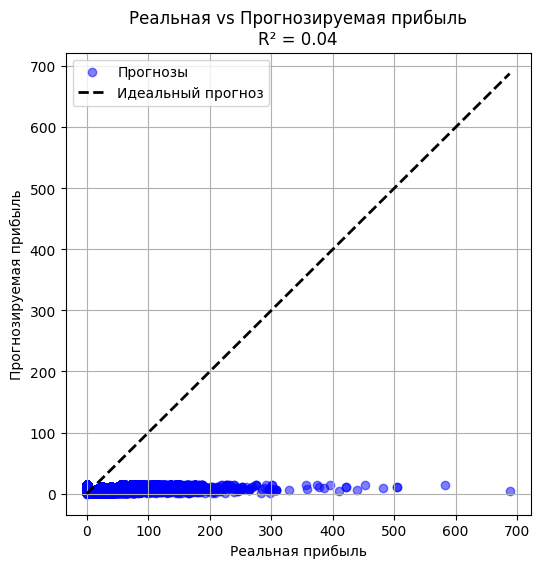

In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train) #Преобразование данных в формат DMatrix
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # Регрессия с квадратичной ошибкой
    'max_depth': 9,                  # Максимальная глубина дерева
    'eta': 0.1,                      # Скорость обучения
    'subsample': 0.8,                # Доля данных для каждого дерева
    'colsample_bytree': 0.8,         # Доля признаков для каждого дерева
    'seed': 42
}


model = xgb.train(params, dtrain, num_boost_round=100) # сама моделька

y_pred = model.predict(dtest) # наш прогноз

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test, y_pred) # Коэф. детерминации, чтобы заодно проверить, как модель объясняет дисперсию данных

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Прогнозы')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Идеальный прогноз')
plt.xlabel('Реальная прибыль')
plt.ylabel('Прогнозируемая прибыль')
plt.title(f'Реальная vs Прогнозируемая прибыль\nR² = {r2:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Получилось, конечно, отвратительно, хотя, если просто посчитать общую прибыль в test и сравнить с прогнозируем, то получается не так отвратительно: 3904021 в тесте против 4490457 в прогнозе. Хотя то, что прибыль завышается, конечно, тоже плохо.


Я думаю, что проблем в том, что я делал ставку в том числе на basket, order и click, не подумав о том, что их нет в тестовой выборке и я не смогу их использовать. А они могли бы помочь. К тому же, стоило поработать с подбором параметров

In [29]:
test_df['actual_revenue'].sum()

np.float64(3904021.8200000017)

In [30]:
y_pred.sum()

np.float32(4490457.0)